In [12]:
%matplotlib inline
import numpy as np
import sklearn as skl
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, OneSidedSelection
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('darkgrid')


資料預處理

In [13]:
from sklearn.preprocessing import LabelEncoder as LE
train_path = './TraData.csv'
data = pd.read_csv(train_path, sep=',') # .sample(20000) # toy
label = data.click
del data['click'] # 記得別讓答案變成一組 feature ，這樣 model 就直接看到答案了
# 只選 adx, spaceType, spaceId, ip, 因為只有這四組 feature 對 click 的影響是顯著的
del data['spaceCat']
del data['adType']
del data['os']
del data['deviceType']
del data['publisherId']
del data['dclkVerticals']
del data['campaignId']
del data['advertiserId']
le_list = {}
for key, value in data.iteritems():
    le_list[key] = LE()
    data[key] = le_list[key].fit_transform(value) ## csv 檔中 feature 均為屬性資料
print data.sample(3) ## 印出三筆資料觀察




        adx  spaceType  spaceId      ip
28482     1          1      166   54243
785893    1          1       63  235220
948588    1          1       63  202446


設定模型參數、建構模型

In [14]:
## DT on sklearn is based on CART algorithm. Let's try ID3&CART algorithm both. And SVM.
classifiers = {
               'DT_CART_opt':tree.DecisionTreeClassifier(), 'RF_CART_opt':RandomForestClassifier(),
               'BoostDT_CART_opt':AdaBoostClassifier(tree.DecisionTreeClassifier(), n_estimators=30),
               'DT_ID3':tree.DecisionTreeClassifier(criterion="entropy"), 'RF_ID3':RandomForestClassifier(criterion="entropy"),
               'BoostDT_ID3':AdaBoostClassifier(tree.DecisionTreeClassifier(criterion="entropy"), n_estimators=30),
               # 'SVM':SVC(), 
               # 'MLP(NN)': MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), 
                                        #activation='relu', max_iter=50, momentum=0.9, early_stopping=True, learning_rate_init=0.001,
                                        #nesterovs_momentum=True, shuffle=True, verbose=True),
               #'Random':DummyClassifier('uniform'), ## 下面這兩個是 baseline ，不應該比亂猜/都猜0還差
               #'Guess0':DummyClassifier('most_frequent')
              }

10-fold Cross-validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
rus = OneSidedSelection()
kfold = StratifiedKFold(n_splits=3, shuffle=True)
for model_name, model in classifiers.items():
    print('Training %s...'%model_name)
    cvscores = []
    for train, test in kfold.split(data, label):
        X, y = rus.fit_sample(data.iloc[train], label.iloc[train])
        model.fit(X,y)
        pred = model.predict(data.iloc[test])
        score = f1_score(pred, label.iloc[test])
        cvscores.append(score)
    print("f1.avg: %.4f%% (+/- %.4f%%)" % (np.mean(cvscores)*100., np.std(cvscores)*100.)) ## validation 的 f1-score 的平均值 +/- 兩倍標準差

Training DT_CART_opt...
f1.avg: 3.6331% (+/- 0.4528%)
Training BoostDT_ID3...


In [9]:
from sklearn.model_selection import train_test_split
clf = classifiers['BoostDT_CART_opt']
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.1)
X_train, Y_train = rus.fit_sample(X_train, Y_train)
clf.fit(X_train, Y_train)
predicted = clf.predict(X_test)
confusion_metrix = skl.metrics.confusion_matrix(Y_test, predicted)
inclass_precision = skl.metrics.classification_report(Y_test, predicted)
print confusion_metrix
print inclass_precision

[[96030    65]
 [   46     5]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96095
          1       0.07      0.10      0.08        51

avg / total       1.00      1.00      1.00     96146



PCA 降維、可視化

In [10]:
def plot_embedding(x_emb,y,n,title=''): ## visualization
    cmap = plt.cm.gist_ncar_r
    ax = plt.subplot()
    for l in xrange(n):
        points = x_emb[y==l,:]
        ax.scatter(points[:,0], points[:,1], label=l, c=cmap(float(l)/float(n)))
    ax.legend(loc='lower right', frameon=True, prop={'size': 10})
    ax.set_title(title)
    plt.show()

In [17]:
pcavis = PCA(n_components=2)
embedding = pcavis.fit_transform(X_test)

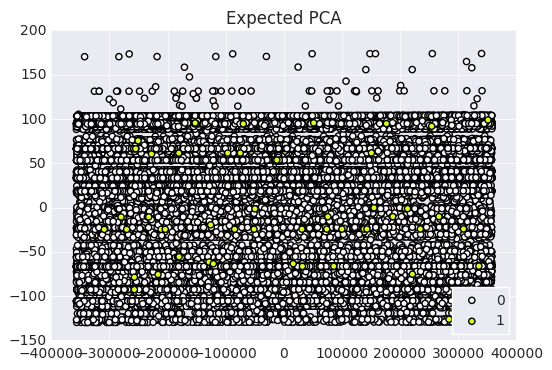

In [18]:
plot_embedding(embedding, Y_test, 2, 'Expected PCA') ## 視覺化, 看起來幾乎不是線性可分的

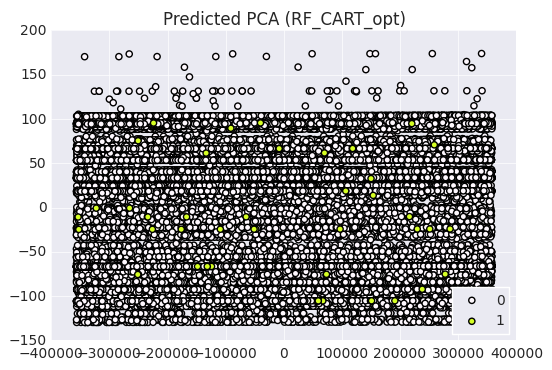

[[96052    43]
 [   49     2]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96095
          1       0.04      0.04      0.04        51

avg / total       1.00      1.00      1.00     96146



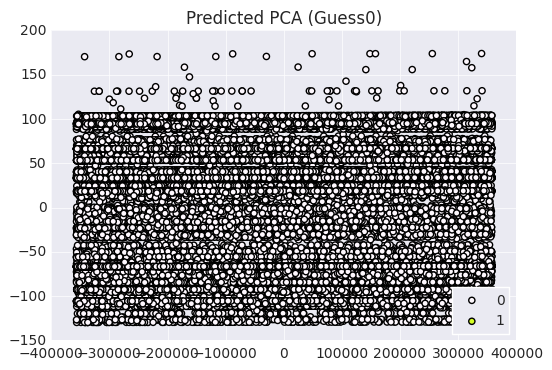

/Users/kuang-yujeng/Library/Python/2.7/lib/python/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[96095     0]
 [   51     0]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96095
          1       0.00      0.00      0.00        51

avg / total       1.00      1.00      1.00     96146



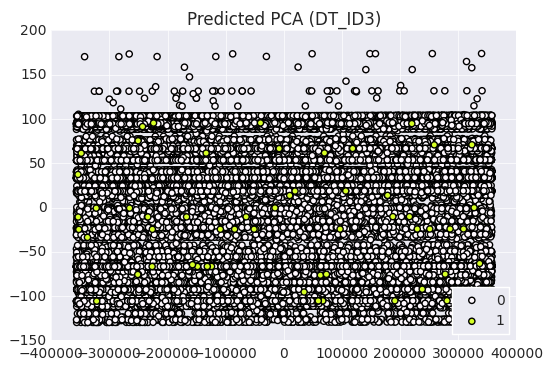

[[96039    56]
 [   46     5]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96095
          1       0.08      0.10      0.09        51

avg / total       1.00      1.00      1.00     96146



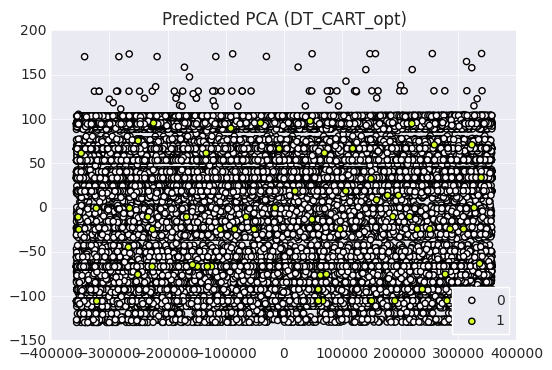

[[96034    61]
 [   46     5]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96095
          1       0.08      0.10      0.09        51

avg / total       1.00      1.00      1.00     96146



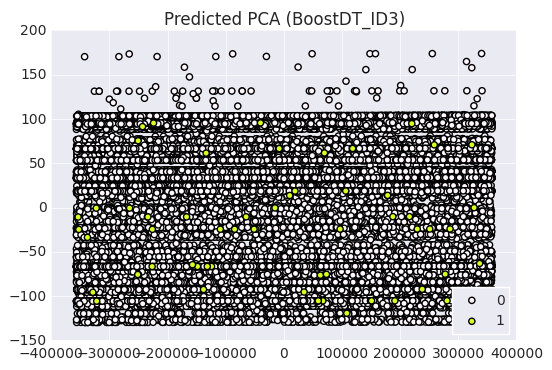

[[96037    58]
 [   47     4]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96095
          1       0.06      0.08      0.07        51

avg / total       1.00      1.00      1.00     96146



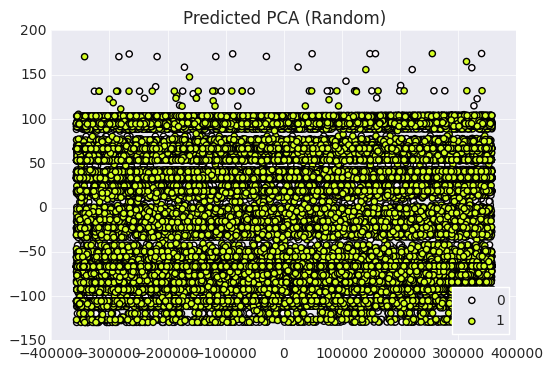

[[48241 47854]
 [   21    30]]
             precision    recall  f1-score   support

          0       1.00      0.50      0.67     96095
          1       0.00      0.59      0.00        51

avg / total       1.00      0.50      0.67     96146



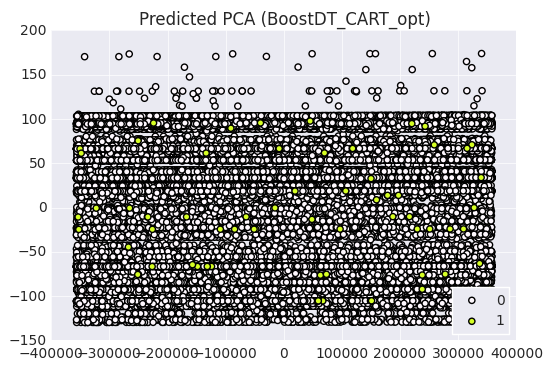

[[96034    61]
 [   46     5]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96095
          1       0.08      0.10      0.09        51

avg / total       1.00      1.00      1.00     96146



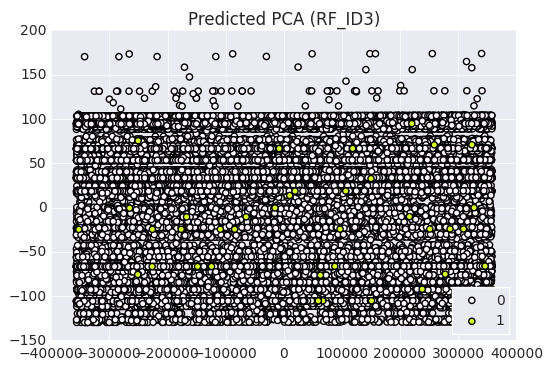

[[96055    40]
 [   48     3]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96095
          1       0.07      0.06      0.06        51

avg / total       1.00      1.00      1.00     96146



In [20]:
for model_name, model in classifiers.items(): ## 但也不能高興得太早，recall 看起來應該不會太好
    model.fit(X_train,Y_train)
    predicted = model.predict(X_test)
    confusion_metrix = skl.metrics.confusion_matrix(Y_test, predicted)
    plot_embedding(embedding, predicted, 2, 'Predicted PCA (%s)'%model_name)
    inclass_precision = skl.metrics.classification_report(Y_test, predicted)
    print confusion_metrix   ## 看看每個 model 在未知的資料上表現如何，判斷模型是否 underlearning, 注意，我們只在乎 label==1 的部分
    print inclass_precision  ## 同上

看來挺糟糕的 :\

補充從 R script 得到的這份 training data 的 ANOVA 結果（從九十萬筆資料隨機抽樣5000筆資料）：

```R
               Df Sum Sq  Mean Sq   F value Pr(>F)    
adx             1  0.000 0.000003 2.192e+23 <2e-16 ***
spaceType       1  0.000 0.000011 9.356e+23 <2e-16 ***
spaceId       128  0.516 0.004034 3.451e+26 <2e-16 ***
ip           4839  3.480 0.000719 6.154e+25 <2e-16 ***
os              3  0.000 0.000000 2.000e-03 0.9999    
campaignId      1  0.000 0.000000 3.089e+00 0.0911 .  
advertiserId    1  0.000 0.000000 1.496e+00 0.2327    
Residuals      25  0.000 0.000000                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
```

可以看出 adx, spaceType, spaceId, ip 對 click 的影響似乎是顯著的？

也許可以實驗看看只選擇 adx, spaceType, spaceId, ip 當作 feature？或是使用 PCA 做降維？

因為他們對 click 的影響較顯著？ p<0.05